In [1]:
import numpy as np
import tensorflow as tf
import random as rn
from my_utils import Workout_dataset, class_weight_dict
from my_model import make_CNN_RNN_model

import os

In [2]:
# seed 고정
os.environ['PYTHONHASHSEED'] = str(42)

os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

tf.random.set_seed(42)
np.random.seed(42)
rn.seed(42)

In [3]:
def scheduler(epoch, lr):
    if (epoch>20) and (lr > 0.00001):
        lr = lr*0.9
        return lr
    else:
        return lr

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

train_dir = './data/train'
label_dir = './data/data_y_train.csv'
test_dir = './data/test'
test_label_dir = './data/data_y_test.csv'
checkpoint_filepath = './save/cnn_gru_best.hdf5'

BATCH_SIZE = 64

train_loader = Workout_dataset(
    train_dir, label_dir, mode='Train',
    fold=0, batch_size=BATCH_SIZE, augment=True, shuffle=True)

valid_loader = Workout_dataset(
    train_dir, label_dir, mode='Valid',
    fold=0, batch_size=16, shuffle=True)

test_loader = Workout_dataset(
    test_dir, test_label_dir, mode='Test',
    batch_size=625, shuffle=False)


In [4]:
model = make_CNN_RNN_model(
    lr = 0.001,
    leakyrelu_alpha = 0.2,
    input_kernels = 10,
    input_kernel_width = 3,
    res_kernels = 60,
    res_kernel_width = 3,
    res_regularize_coeff=0.01, #0.2
    res_num = 15, # 3, #5#, 7, #9#
    )

model.summary()

____________________
leaky_re_lu_37 (LeakyReLU)      (None, 150, 60)      0           batch_normalization_37[0][0]     
__________________________________________________________________________________________________
add_5 (Add)                     (None, 150, 60)      0           leaky_re_lu_37[0][0]             
                                                                 add_4[0][0]                      
__________________________________________________________________________________________________
conv1d_29 (Conv1D)              (None, 150, 60)      32460       add_5[0][0]                      
__________________________________________________________________________________________________
batch_normalization_38 (BatchNo (None, 150, 60)      240         conv1d_29[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_38 (LeakyReLU)      (None, 150, 60)      0           batch_normalization_38[

In [5]:

save_best = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch', options=None)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',min_delta=0.0001,
    patience=20,verbose=1)

history = model.fit(
    train_loader,
    validation_data=valid_loader,
    epochs=2000,
    callbacks=[save_best,early_stop,lr_scheduler],
    class_weight=class_weight_dict)


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/2000
34/34 [==============================] - 45s 362ms/step - loss: 65.7597 - accuracy: 0.3024 - val_loss: 48.2466 - val_accuracy: 0.4453

Epoch 00001: val_loss improved from inf to 48.24656, saving model to ./save/cnn_gru_best.hdf5
Epoch 2/2000
34/34 [==============================] - 8s 230ms/step - loss: 40.5264 - accuracy: 0.5409 - val_loss: 29.9016 - val_accuracy: 0.4531

Epoch 00002: val_loss improved from 48.24656 to 29.90164, saving model to ./save/cnn_gru_best.hdf5
Epoch 3/2000
34/34 [==============================] - 8s 237ms/step - loss: 25.2888 - accuracy: 0.6347 - val_loss: 19.2145 - val_accuracy: 0.4414

Epoch 00003: val_loss improved from 29.90164 to 19.21450, saving model to ./save/cnn_gru_best.hdf5
Epoch 4/2000
34/34 [==============================] - 8s 229ms/step - loss: 16.5248 - accuracy: 0.6774 - val_loss: 13.0738 - val

In [6]:
model.load_weights(checkpoint_filepath)
model.evaluate(test_loader,verbose=1)

1/1 [==============================] - 1s 1s/step - loss: 0.7776 - accuracy: 0.8240


[0.7775841951370239, 0.8240000009536743]

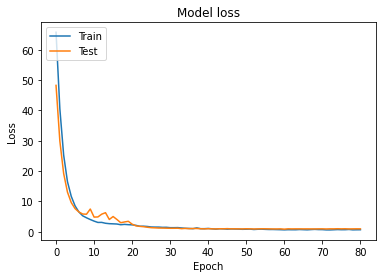

In [7]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()